In the previous lesson we learned about the [Basemap][1] mapping toolkit for the matplotlib library. We also played around with it a bit to create a simple, aesthetically pleasing map of the world, but aside from being able to see the general location of each country in the world, our map wasn't necessarily packed with information. In this lesson, we'll use the basemap toolkit to create a chorlopleth map. 

A [choropleth][2] is a [thematic map][3] in which areas are shaded, patterned, or colored to represent some underlying value associated with a particular phenomenon. In this lesson, the phenomenon we'll be studying is unemployment. Specifically, we'll be looking at the unemployment rate per county in the US before, during, and after the [Great Recession][4].

Let's not waste anymore time talking about the task at hand, let's dive right in and get set up.

[1]: http://matplotlib.org/basemap/
[2]: https://en.wikipedia.org/wiki/Choropleth_map
[3]: https://en.wikipedia.org/wiki/Thematic_map
[4]: https://en.wikipedia.org/wiki/Great_Recession_in_the_United_States

In [30]:
%matplotlib inline

import numpy as np
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, Polygon

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# The current version of NumPy available from conda is issuing a warning 
# message that some behavior will change in the future when used with the 
# current version of matplotlib available from conda. This cell just keeps
# that warning from being displayed.
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Loading the Unemployment Data

Just as we did in our earlier lessons, in this lesson, we'll again be making use of `namedtuple`s to wrap each unemployment record making the data easier to work with throughout the rest of the lesson. 

The code below creates an `UnemploymentRecord` constructor with the namedtuple function. Of the fields listed below, the two that we are most concerned with, are the [FIPS code][1] and the unemployment rate. The FIPS code is a five-digit unique identifier for each of the counties in the US, and we'll be using it to match up the unemployment rate to the county object in the shapefile that we'll read in later. This will allow us to color the county according to its unemployment rate.

[1]: https://en.wikipedia.org/wiki/FIPS_county_code

In [31]:
from collections import namedtuple

UnemploymentRecord = namedtuple('UnemploymentRecord', ('laus_code', 
                                                       'fips_code', 
                                                       'name', 
                                                       'year',
                                                       'labor_force',
                                                       'employed',
                                                       'unemployment_level',
                                                       'unemployment_rate'))

Now that we have our `UnemploymentRecord` constructor, we're ready to read in the data. Since we're going to be loading data from multiple years, it makes sense to create a function for doing this task, so we don't end up copying and pasting the code to do so in multiple places. 

The code below creates a function called `load_unemployment_rates` that takes one parameter, a year as an integer value, and downloads the data for the given year and returns a list of `UnemploymentRecord` objects. 

In [32]:
import urllib2
import xlrd

# The URL for the Labor Force Data by County, or Local Area 
# Unemployment Statistics (LAUS), from the Bureau of Labor Statistics
base_url = "http://www.bls.gov/lau/laucnty%02d.xlsx"

def load_unemployment_rates(year):
    """Loads the unemployment data for the given year from the BLS.
    
    Arguments:
    year -- The year (as an int) to load unemployment data for
    """
    url = base_url % (year - 2000)
    response = urllib2.urlopen(url)
    workbook = xlrd.open_workbook(file_contents=response.read())
    sheet = workbook.sheet_by_index(0)
    
    data = []
    for i in range(6, sheet.nrows-4):
        row = sheet.row_values(i)
        data.append(UnemploymentRecord(
            laus_code           = row[0],
            fips_code           = row[1] + row[2],
            name                = row[3],
            year                = int(row[4]),
            # For some reason, they have an extra, empty column here
            labor_force         = int(row[6]) if row[6] != 'N.A.' else 0,
            employed            = int(row[7]) if row[7] != 'N.A.' else 0, 
            unemployment_level  = int(row[8]) if row[8] != 'N.A.' else 0,
            unemployment_rate   = float(row[9]) if row[9] != 'N.A.' else 0.))
        
    return data

We'll be pulling down the data from the [Bureau of Labor Statistics][1]. Specifically, we are grabbing the [county unemployment data][2] in the Excel format. If you navigate to the Bureau of Labor Statistics' website, you'll notice that the data is also available in a text format, but at least for me, the formatting was harder to parse since it wasn't in a comma, or tab delimited format. So, I just chose to go with Excel version, since the wonderful [xlrd][3] library is available as a conda install, and it makes it very convenient to read in the data from an Excel file. Given this requirement, before you can run the code in the `load_unemployment_rates` function, you'll need to do a quick `conda install xlrd` to install the required package.

The code for the `load_unemployment_rates` function is really quite straightforward. We simply download the data for the given year, parse it with the xlrd library, and wrap each row's data in an `UnemploymentRecord` tuple. The only bit of preprocessing we do on the data, can be seen on lines 24 and 26-31. On line 24, we concatnate the state and country FIPS codes into a single FIPS code string since that is what the shapefile of the counties uses, and on lines 26-31 we cast some of the data, such as the unemployment rate, into `int`s and `float`s. To do so, we have to be a bit careful, since in some records, we get `'N.A.'` as the value. In those cases, we simply set the value to 0. 

## Create a Color Function

To create our choropleth, we need a way to map an unemployment rate to a color. In the next bit of code we create a function that will take a list of unemployment rates and return a function that maps an unemployment to a color. 

In [48]:
class HexColorMapper(plt.cm.ScalarMappable):
    """A color mapper that maps values to hexidicimal values
    """
    def __init__(self, data=None, cmap=None):
        norm = mpl.colors.Normalize(vmin=min(data), vmax=max(data))
        super(HexColorMapper, self).__init__(norm, cmap)
    def __call__(self, value):
        return rgb2hex(self.to_rgba(value))  

The mapper function itself is very simple---just a single line of code. In that one line of code, it normalizes the given unemployment rate, gets a corresponding color from the `pyplot.cm.hot` color map, and turns the color into a hexidecimal value before returning it. The only thing here that really merits further discussion is the where we subtract the normalized value from 1. The reason for this is that 'hot' color map runs from hot, i.e., the low index value, to cold, so we need to essentially invert the normalized value, so that high values show up as hot colors and low values as cold. 

The `get_color_mapper` wrapper function takes a list of unemployment rates and gets their min and max values so it can create a normalizing function. Fortunately for us, the matplotlib `matplotlib.colors` modules provides us with a class for creating  

First, it normalizes the given unemployment rate by dividing the difference between the rate and the minimum rate in the set and dividing by the total difference between the min and max values. This will make sure that all of our unemployment rates will be between 0 and 1 which is exactly the range of values that a matplotlib color map expects. Next, we'll call an instance of a matplotlib color map with the normalized value. This will return a tuple of red, blue, green, and alpha values that we will then pass to matplotlib's `rgb2hex` before returning the hex value for the color to the caller. All of this takes palce inside of the internal function `mapper` below.

Finally, we wrap the `mapper` function in a factory function called `get_color_mapper` that takes a list of unemployment rates and an optional color map instance and returns a new instance of our `mapper` function. The reason for this is to make it easy to try out different color maps with our choropleth to find the one that looks best with our data.

## Drawing the Choropleth

In this section we'll create a function that will draw the choropleth for a given set of unemployment rates. This function will take an instance of the `Basemap` class, a dict of unemployment rates, and a function for mapping unemployment rates to colors. Our function will only be dawing the 48 contiguous states, so we'll also need to create a list of the FIPS codes for just those states that we can use in our drawing function.

The drawing function itself is relatively simple since it assumes that the Basemap object is completely setup at the time it's passed in. Completely setup means that the shapefile for the counties has already been properly loaded into the `Basemap` object. The main functionality of our drawing function will be to loop through every county in the given `Basemap` object and add a patch to the map object containing a `Polygon` instance that will visually represent that county. To make the map a choropleth, we will first look up the unemployment rate for the county, get its cooresponding color value, and then fill the polygon with that color. This will give our map that familiar patchwork look of a choropleth.

In [7]:
# List of the FIPS codes for the 48 contiguous states 
# source: http://www.bls.gov/cew/cewedr10.htm)
contiguous_states_fips = [
    '01',   # Alabama 
    '04',   # Arizona 
    '05',   # Arkansas    
    '06',   # California  
    '08',   # Colorado    
    '09',   # Connecticut 
    '10',   # Delaware    
    '11',   # District of Columbia    
    '12',   # Florida 
    '13',   # Georgia 
    '16',   # Idaho   
    '17',   # Illinois    
    '18',   # Indiana 
    '19',   # Iowa    
    '20',   # Kansas  
    '21',   # Kentucky    
    '22',   # Louisiana   
    '23',   # Maine   
    '24',   # Maryland    
    '25',   # Massachusetts   
    '26',   # Michigan    
    '27',   # Minnesota   
    '28',   # Mississippi 
    '29',   # Missouri    
    '30',   # Montana 
    '31',   # Nebraska    
    '32',   # Nevada  
    '33',   # New Hampshire   
    '34',   # New Jersey  
    '35',   # New Mexico  
    '36',   # New York    
    '37',   # North Carolina  
    '38',   # North Dakota    
    '39',   # Ohio    
    '40',   # Oklahoma    
    '41',   # Oregon  
    '42',   # Pennsylvania    
    '44',   # Rhode Island    
    '45',   # South Carolina  
    '46',   # South Dakota    
    '47',   # Tennessee   
    '48',   # Texas   
    '49',   # Utah    
    '50',   # Vermont 
    '51',   # Virginia    
    '53',   # Washington  
    '54',   # West Virginia   
    '55',   # Wisconsin   
    '56',   # Wyoming 
]

In [8]:
def draw_choropleth(m, data, color):
    """Draws a choropleth.
    
    Arguments:
    m -- The map projection
    data -- The unemployment data
    color -- A function that takes an unemployment rate and returns 
             a hex value representing a color.
    """
    # Convert the unemployment data into a dict mapping FIPS codes to unemployment_rates
    unemployment_rates = {r.fips_code: r.unemployment_rate for r in data}
    
    # Draw all of the counties to the current axes
    ax = plt.gca()
    for info, shape in zip(m.counties_info, m.counties):
        # We're only showing unemployment rates for the 48 contiguous states, 
        # so skip anything that doesn't show up in the list.
        if info['STATEFP'] not in contiguous_states_fips:
            continue
        try:
            fips = info['STATEFP'] + info['COUNTYFP']
            unemployment_rate = unemployment_rates[fips]
        except KeyError:
            continue
        ax.add_patch(Polygon(np.array(shape), facecolor=color(unemployment_rate), edgecolor='#221e1f', linewidth=0.5))    

    # Calling drawmapboundary will ensure that the x- and y-axis 
    # limits are set correctly for the map and draws either simple 
    # border (or no border as in our example below) in place of a 
    # typical x- and y-axis with tick marks.
    m.drawmapboundary(color='none');

## Create the Map Object

In [9]:
# Lambert Conformal map of lower 48 states.
m = Basemap(
    # These four attributes define the bounding box, 
    # i.e., the area of the world that we want to show 
    # in our map.
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    # We've chosen the Lambert Conformal Conic projection. 
    projection='lcc',
    # These three params define the 1st and 2nd standard 
    # parallel and the central meridian used by the projection.
    lat_1=33,          
    lat_2=45,
    lon_0=-95
   )

## Load the Counties Shapefile

[counties shapefile][1]

[1]: https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html

In [10]:
# Set drawbounds to False to make sure the map isn't drawn in this step
m.readshapefile('./shapefiles/cb_2014_us_county_500k_2d/cb_2014_us_county_500k', 'counties', drawbounds=False);

## The Great Recession

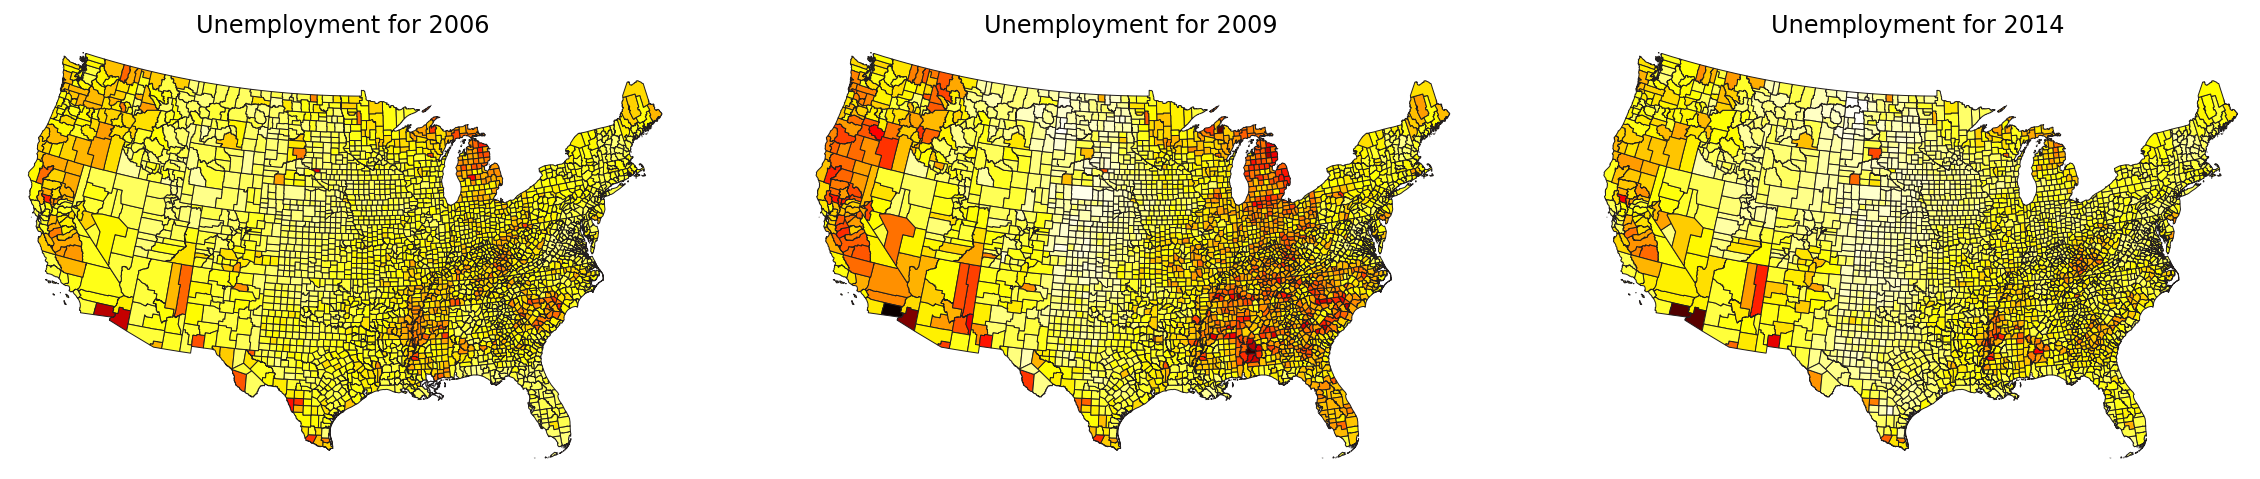

In [16]:
# The Great Recession began in 2007 and hit its peak in 2009. 
# We'll look at the unemployment rate, before it began, at its
# peak, and finally the most recent year that we have data for.
years = [2006, 2009, 2014]

plt.figure(figsize=(20, 10))
for i, year in enumerate(years):

    # Get the data from the file
    data = load_unemployment_rates(year)
    color = get_color_mapper([r.unemployment_rate for r in data])

    # Create a new subplot and add a title
    plt.subplot(1, len(years), i+1)
    plt.title('Unemployment for %s' % year)
    
    # Draw the map
    draw_choropleth(m, data, color)

## The Peak of the Recession

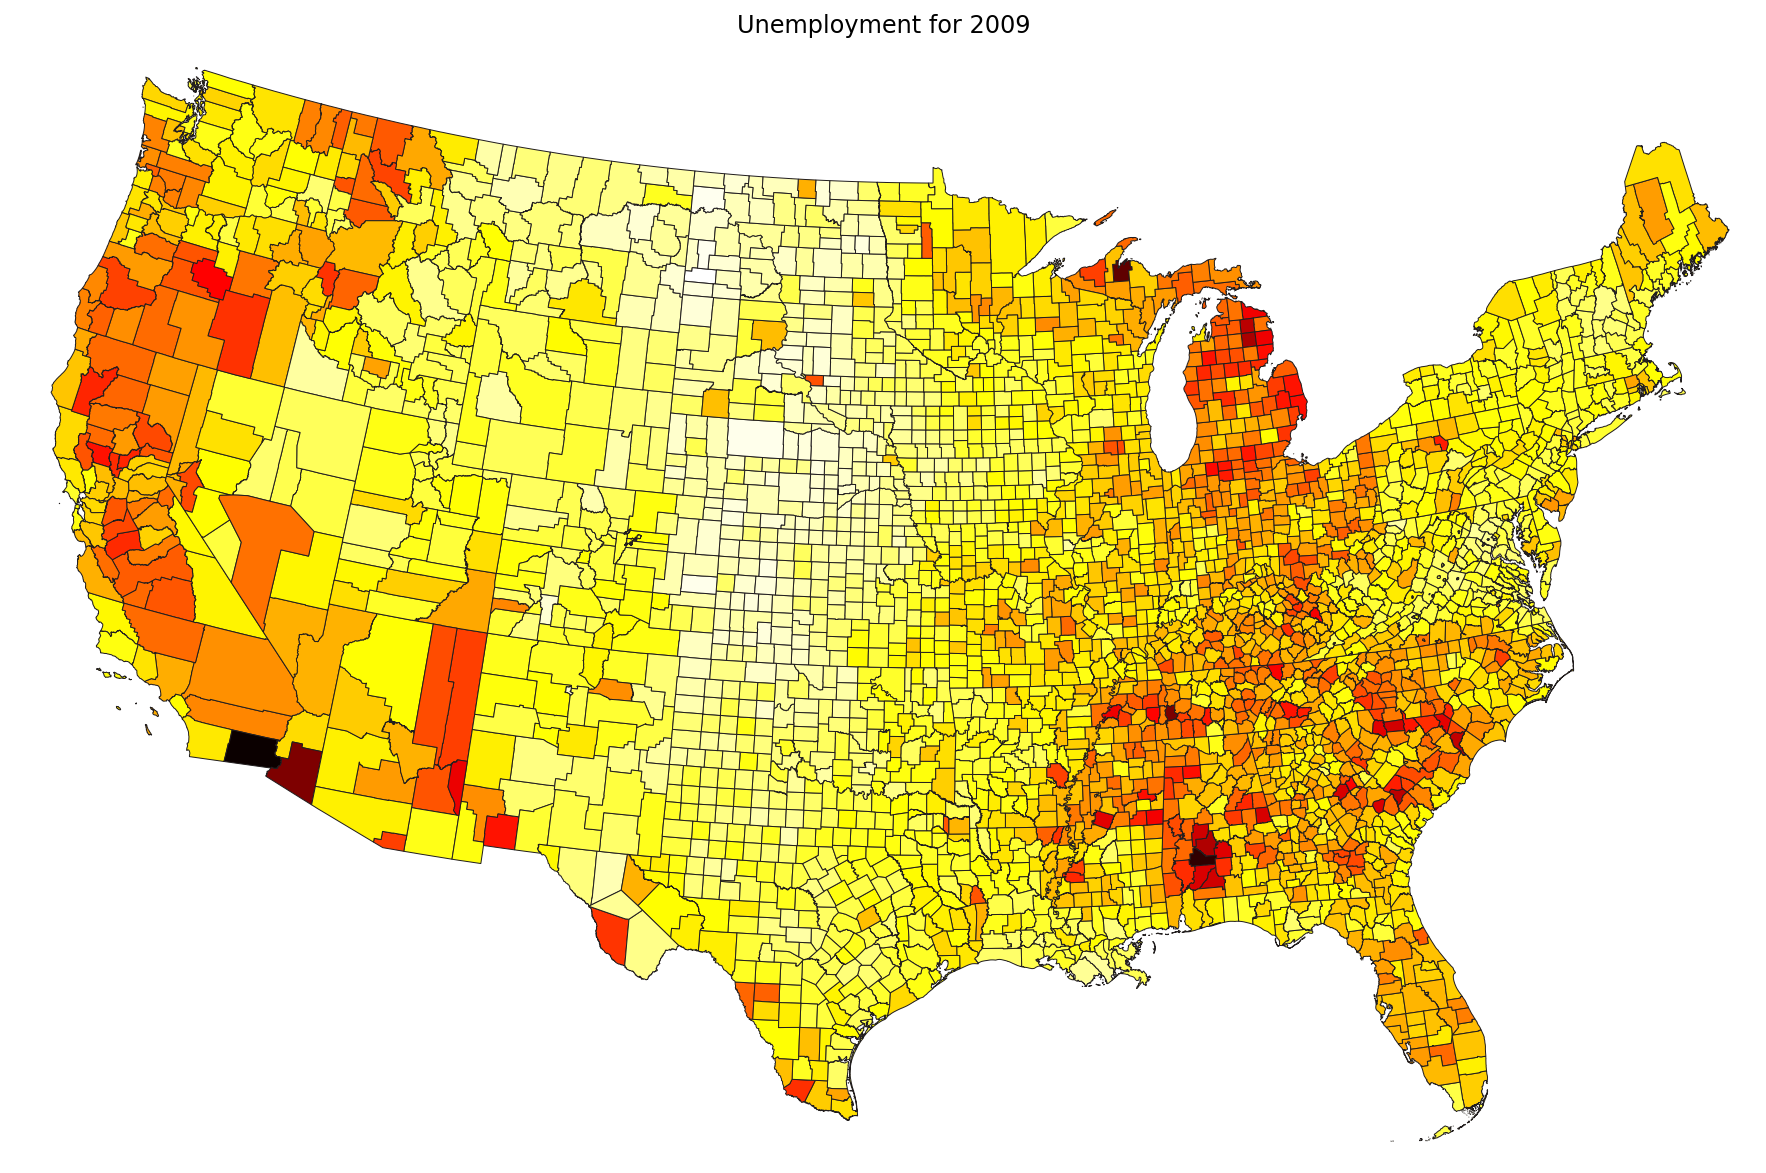

In [51]:
plt.figure(figsize=(20,10))
plt.title("Unemployment for 2009")
data = load_unemployment_rates(2009)
#color = get_color_mapper([r.unemployment_rate for r in data])
color = HexColorMapper([r.unemployment_rate for r in data], plt.cm.hot_r)
draw_choropleth(m, data, color)